## 7.1 线性可分支持向量机
### 例 7.2
训练数据集为T，其中正例点为$x_1 = (3, 3)^T, x_2=(4, 3)^T$，负例点为$x_3=(1, 1)^T$，试用算法 7.2 求**线性可分支支持向量机**

根据*算法7.2*，负对偶问题表示如下
$$
\begin{aligned}
\min_{\alpha} &\frac{1}{2}\sum_{i=1}^N\sum_{j=1}^N{\alpha_i\alpha_j y_i y_j(x_i\cdot x_j)} - \sum_{i=1}^N \alpha_i\\
&=\frac{1}{2}(18 \alpha_1^2  + 21\alpha_1\alpha_2 - 6\alpha_1\alpha_3 + 25\alpha_2^2 + 21\alpha_1\alpha_2 - 7\alpha_2\alpha_3 + 2\alpha_3^2 - 6\alpha_1\alpha_3 - 7\alpha_2\alpha_3) - \sum_{i=1}^3 \alpha_i\\
&=\frac{1}{2}(18\alpha_1^2 + 25\alpha_2^2 + 2\alpha_3^2 + 42\alpha_1\alpha_2 - 12\alpha_1\alpha_3 - 14\alpha_2\alpha_3) - \sum_{i=1}^3 \alpha_i\\
\text{s.t.} & \sum_{i=1}y_i\alpha_i = \alpha_1 + \alpha_2 - \alpha_3 = 0\\
&\alpha_i \ge 0, i = 1, 2,\cdots, N
\end{aligned}
$$

In [1]:
import numpy as np
from scipy.optimize import minimize
# 负对偶问题
func = lambda alpha : 9 * (alpha[0] ** 2) + 12.5 * (alpha[1] ** 2) + alpha[2] ** 2 + 21 * alpha[0] * alpha[1] - 6 * alpha[0] * alpha[2] - 7 * alpha[1] * alpha[2] - alpha[0] - alpha[1] - alpha[2]
# 约束条件
contraints = (
    {'type' : 'eq', 'fun' : lambda alpha : alpha[0] + alpha[1] - alpha[2]},
    {'type' : 'ineq', 'fun' : lambda alpha : alpha[0]},
    {'type' : 'ineq', 'fun' : lambda alpha : alpha[1]},
    {'type' : 'ineq', 'fun' : lambda alpha : alpha[2]}
)
# 优化的初始值
alpha = np.array([0.0, 0.0, 0.0])
# 使用scipy进行目标优化
res = minimize(fun=func, x0=alpha, method='SLSQP', constraints=contraints)
# 打印优化结果，由于浮点数精度的原因，输出与实际有所误差
print(f"state : {res.success}, alpha[0] = {res.x[0]}, alpha[1] = {res.x[1]}, alpha[2] = {res.x[2]}")

state : True, alpha[0] = 0.2499999819147799, alpha[1] = 5.822165666247159e-17, alpha[2] = 0.24999998191477996


**从上述输出结果来看**，求得**拉格朗日算子的近似解**$\alpha = (0.25, 0, 0.25)^T$。下一步，根据算法 7.2 提供的公式，求得参数$w^*, b^*$。
$$
\begin{aligned}
w^* &= \alpha_1(3,  3) + \alpha_2 (4 ,  3) - \alpha_3 (1 ,  1)\\
&= (3\alpha_1, 3\alpha_1) + (4\alpha_2, 3\alpha_2) - (\alpha_3, \alpha_3) \\
&=(3\alpha_1 + 4\alpha_2 - \alpha_3 , 3 \alpha_1 + 3\alpha_2 - \alpha_3)\\
&= (\frac{1}{2}, \frac{1}{2})\\
b^* &=y_j - \sum_{i=1}^N\alpha^* y_i(x_i\cdot x_j)\\
&=y_1 - \sum_{i=1}^N\alpha^*_i y_i(x_i\cdot x_1)\\
&= 1 - (0.25 * 18 + 0 * 21 - 0.25  * 6)\\
&= -2
\end{aligned}
$$
所以，线性可分SVM的线性可分超平面表示如下
$$
\begin{aligned}
\frac{1}{2}x^{(1)} + \frac{1}{2} x^{(2)} -2 = 0
\end{aligned}
$$

**下面是基于对偶学习算法的线性可分SVM模型**

In [176]:
class LsSVM:
    """Linear Separable Support Vector Machine"""
    def __init__(self, dataset, alpha):
        """
        :param dataset: {data : label}
        """
        self.dataset = dataset
        self.alpha_num = self.dataset.__len__()
        self.alpha = np.array(alpha)
        # contraints
        constraints_eq = [
            {'type' : 'ineq', 'fun' : lambda alpha, i=i : alpha[i]} for i in range(self.alpha_num)
        ]
        constraints_ineq = [
            {'type' : 'eq', 'fun' : self.ineq}
        ]
        self.constraints = tuple(constraints_eq + constraints_ineq)

    def function(self, alpha):
        """ minimize the negative dual problem """
        value = 0
        for i, key_i in enumerate(self.dataset):
            x_i = np.array(key_i)
            y_i = np.array(self.dataset[key_i])
            alpha_i = alpha[i]
            for j, key_j in enumerate(self.dataset):
                x_j = np.array(key_j)
                y_j = np.array(self.dataset[key_j])
                alpha_j = alpha[j]
                value = value + alpha_j * alpha_i * y_i * y_j * sum(x_i * x_j)
        value = value * 0.5 - sum(alpha)
        return value

    def ineq(self, alpha):
        value = 0
        for i, key_i in enumerate(self.dataset):
            value = value + alpha[i] * np.array(self.dataset[key_i])
        return value

    def optimize(self, method='SLSQP'):
        print('# -------------------------------------------------- #')
        print('#            minimize negative problem               #')
        print('# ----- -------------------------------------------- #')
        res = minimize(fun=self.function, x0=self.alpha, method=method, constraints=self.constraints)
        print(f"state : {res.success}")
        for i in range(1, self.alpha_num + 1):
            print(f"alpha_{i} = {res.x[i - 1]}")
        print(res.message)
        self.res = res
        self.w = self.get_w(res.x)
        self.b = self.get_b(res.x)

        print('# -------------------------------------------------- #')
        print('#                  solve w and b                     #')
        print('# -------------------------------------------------- #')
        print(f"w = {self.w}")
        print(f"b = {self.b}")
        print('# -------------------------------------------------- #')
        print('#                     finish                         #')
        print('# ----- -------------------------------------------- #')

    def get_w(self, alpha):
        w = 0
        for idx, key_i in enumerate(self.dataset):
            x_i = np.array(key_i)
            y_i = np.array(self.dataset[key_i])
            alpha_i = alpha[idx]
            w = w + alpha_i * y_i * x_i
        return w

    def get_b(self, alpha):
        for idx, key in enumerate(self.dataset):
            if alpha[idx] > 0:
                x_j = np.array(key)
                y_j = np.array(self.dataset[key])
                break
        b = y_j
        for idx, key_i in enumerate(self.dataset):
            x_i = np.array(key_i)
            y_i = np.array(self.dataset[key_i])
            alpha_i = alpha[idx]
            b = b - alpha_i * y_i * sum(x_i * x_j)
        return b

    def predict(self, input):
        """
        decision function for Linear Separable SVM
        :param input: x1(2, 2)
        :return: predict label
        """
        distance = 0
        for i in range(len(input)):
            distance = distance + self.w[i] * input[i]
        distance = distance + self.b
        return self.sign(distance)


    def sign(self, x):
        if x >= 0 :
            return 1
        else:
            return -1




**演示过程**

In [193]:
import matplotlib.pyplot as plt
# 训练数据集 （与例7.2一致）
dataset = { (2, 3) : 1, (4, 2) : 1, (5, 5) : 1, (2, 2) : 1, (1, 1): -1, (1.5, 5) : -1, (0.5, 4) : -1}
# 拉格朗日算子的初始值（任意）
alpha = [0.] * dataset.__len__()
# 初始化 线性可分SVM模型
lsvm = LsSVM(dataset, alpha)
# 求解 拉格朗日算子 和 w, b 参数
lsvm.optimize()

# -------------------------------------------------- #
#            minimize negative problem               #
# ----- -------------------------------------------- #
state : True
alpha_1 = 3.6107595225109526
alpha_2 = -5.43085005472703e-15
alpha_3 = -1.8332906650186267e-15
alpha_4 = 3.2363434848692307e-16
alpha_5 = 1.7220325729002315
alpha_6 = 1.8887269496107202
alpha_7 = -5.850405205605347e-15
Optimization terminated successfully
# -------------------------------------------------- #
#                  solve w and b                     #
# ----- -------------------------------------------- #
w = [ 2.66639605 -0.33338875]
b = -3.3326258351482188
# -------------------------------------------------- #
#                     finish                         #
# ----- -------------------------------------------- #


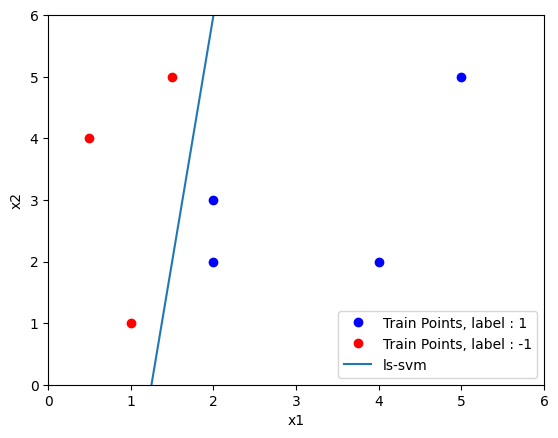

In [197]:
# 预测
label_positive = [[], []]
label_negative = [[], []]
for key in dataset.keys():
    if dataset[key] == 1:
        label_positive[0].append(key[0])
        label_positive[1].append(key[1])
    else:
        label_negative[0].append(key[0])
        label_negative[1].append(key[1])

plt.plot(label_positive[0], label_positive[1], 'bo', label="Train Points, label : 1")
plt.plot(label_negative[0], label_negative[1], 'ro', label="Train Points, label : -1")

x = np.linspace(0, 6, 1000)
y = lambda x : -1 * (lsvm.w[0] * x + lsvm.b) / lsvm.w[1]
plt.plot(x, y(x), label="ls-svm")
plt.xlim(0, 6)
plt.ylim(0, 6)
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()

## 7.2 线性支持向量机与软间隔最大化
![image-20230227185217412](https://qiniu.lianghao.work/image-20230227185217412.png)

In [198]:
class LinearSVM:
    """Linear Support Vector Machine"""
    def __init__(self, dataset, alpha, c):
        """
        :param dataset: {data : label}
        :param alpha: initial alpha
        :param c: penalty value
        """
        self.dataset = dataset
        self.alpha_num = self.dataset.__len__()
        self.c = c
        self.alpha = np.array(alpha)
        # contraints
        constraints_eq = [
            {'type' : 'ineq', 'fun' : lambda alpha, i=i : alpha[i]} for i in range(self.alpha_num)
        ] + [{'type' : 'ineq', 'fun' : lambda alpha, i=i : self.c - alpha[i]} for i in range(self.alpha_num)]
        constraints_ineq = [
            {'type' : 'eq', 'fun' : self.ineq}
        ]
        self.constraints = tuple(constraints_eq + constraints_ineq)

    def function(self, alpha):
        """ minimize the negative dual problem """
        value = 0
        for i, key_i in enumerate(self.dataset):
            x_i = np.array(key_i)
            y_i = np.array(self.dataset[key_i])
            alpha_i = alpha[i]
            for j, key_j in enumerate(self.dataset):
                x_j = np.array(key_j)
                y_j = np.array(self.dataset[key_j])
                alpha_j = alpha[j]
                value = value + alpha_j * alpha_i * y_i * y_j * sum(x_i * x_j)
        value = value * 0.5 - sum(alpha)
        return value

    def ineq(self, alpha):
        value = 0
        for i, key_i in enumerate(self.dataset):
            value = value + alpha[i] * np.array(self.dataset[key_i])
        return value

    def optimize(self, method='SLSQP'):
        print('# -------------------------------------------------- #')
        print('#            minimize negative problem               #')
        print('# ----- -------------------------------------------- #')
        res = minimize(fun=self.function, x0=self.alpha, method=method, constraints=self.constraints)
        print(f"state : {res.success}")
        for i in range(1, self.alpha_num + 1):
            print(f"alpha_{i} = {res.x[i - 1]}")
        print(res.message)
        self.res = res
        self.w = self.get_w(res.x)
        self.b = self.get_b(res.x)

        print('# -------------------------------------------------- #')
        print('#                  solve w and b                     #')
        print('# -------------------------------------------------- #')
        print(f"w = {self.w}")
        print(f"b = {self.b}")
        print('# -------------------------------------------------- #')
        print('#                     finish                         #')
        print('# ----- -------------------------------------------- #')

    def get_w(self, alpha):
        w = 0
        for idx, key_i in enumerate(self.dataset):
            x_i = np.array(key_i)
            y_i = np.array(self.dataset[key_i])
            alpha_i = alpha[idx]
            w = w + alpha_i * y_i * x_i
        return w

    def get_b(self, alpha):
        for idx, key in enumerate(self.dataset):
            if alpha[idx] > 0 and alpha[idx] < self.c:
                x_j = np.array(key)
                y_j = np.array(self.dataset[key])
                break
        b = y_j
        for idx, key_i in enumerate(self.dataset):
            x_i = np.array(key_i)
            y_i = np.array(self.dataset[key_i])
            alpha_i = alpha[idx]
            b = b - alpha_i * y_i * sum(x_i * x_j)
        return b

    def predict(self, input):
        """
        decision function for Linear Separable SVM
        :param input: x1(2, 2)
        :return: predict label
        """
        distance = 0
        for i in range(len(input)):
            distance = distance + self.w[i] * input[i]
        distance = distance + self.b
        return self.sign(distance)


    def sign(self, x):
        if x >= 0 :
            return 1
        else:
            return -1